## Data Prep

**Import necessary modules and the ASOS/SNOTEL dataframes**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dtb
import os
from glob import glob
import datetime as dt
import seaborn as sns

In [2]:
data = [pd.read_csv('asos_snotel_UA_12hr_df.dat', parse_dates = True, index_col = 'Date_Time')]
asos_snotel_UA_df = pd.concat(data)
#asos_snotel_UA_df['LXV_WindSpeed_m/s']

#asos_snotel_UA_df.rename(columns={'LXV_WindSpeed_m/s': 'LXV_WindSpeed_mps'}, inplace=True)

asos_snotel_UA_df.astype('float16')
pd.set_option('display.expand_frame_repr', True)


print(asos_snotel_UA_df.keys())




#delete empty columns as they mess up loops
#del asos_snotel_UA_df['CMtn_6hr_Precipitation_mm']            #empty column


Index(['CMtnSNTL_Temp_degC', 'CMtnSNTL_SnowDepth_in', 'CMtn_Temperature_degC',
       'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps',
       'CMtn_CloudCover_oktas', 'CMtn_1hr_Precipitation_mm',
       'LXV_Temperature_degC', 'LXV_Dewpoint_degC',
       ...
       'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc',
       'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts',
       'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc',
       'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts'],
      dtype='object', length=163)


It is important to keep in mind that 'CMtnSNTL_12hr_SNWD_in contains snow depth info taken at the start of the respective 12hr period timestamp.  The snowfall calculated also gives the snowfall that fell in the 12hrs after the timestamp.  The OLS model will utilize hourly meteorological measurements at exactly 00:00 and 12:00 hours to predict the amount of snow which will fall in the next 12 hour period.  For example, the 00:00 meteorological measurements will be used to predict the snow which fell between 00:00 and 12:00.

In [3]:
all_yrs = (asos_snotel_UA_df.index >= '01-01-2006') & (asos_snotel_UA_df.index < '01-01-2018')
train_yrs = ((asos_snotel_UA_df.index >= '01-01-2006') & (asos_snotel_UA_df.index < '01-01-2014')) | ((asos_snotel_UA_df.index >= '01-01-2015') & (asos_snotel_UA_df.index < '01-01-2018'))
test_yrs = (asos_snotel_UA_df.index >= '01-01-2014') & (asos_snotel_UA_df.index <= '01-01-2015')

test = (asos_snotel_UA_df.index >= '01-01-2006') & (asos_snotel_UA_df.index < '01-02-2006')
print(asos_snotel_UA_df['KGJT_d300_200_height_m'][test])

print(asos_snotel_UA_df[all_yrs]['CMtnSNTL_Temp_degC'].describe())
print(asos_snotel_UA_df[test_yrs]['CMtnSNTL_Temp_degC'].describe())
print(asos_snotel_UA_df[train_yrs]['CMtnSNTL_Temp_degC'].describe())

Date_Time
2006-01-01 00:00:00+00:00   -2630.0
2006-01-01 12:00:00+00:00   -2700.0
Name: KGJT_d300_200_height_m, dtype: float64
count    8710.000000
mean       -0.001883
std         8.559429
min       -30.600000
25%        -6.270000
50%         0.000000
75%         7.300000
max        19.100000
Name: CMtnSNTL_Temp_degC, dtype: float64
count    731.000000
mean      -0.171819
std        8.225395
min      -22.800000
25%       -6.400000
50%       -0.300000
75%        7.000000
max       17.300000
Name: CMtnSNTL_Temp_degC, dtype: float64
count    7980.000000
mean        0.012168
std         8.590244
min       -30.600000
25%        -6.230000
50%         0.100000
75%         7.400000
max        19.100000
Name: CMtnSNTL_Temp_degC, dtype: float64


***
# OLS Analysis of meteorological variables and snowfall (Training Dataset: 2008-2017 only)

**We will first utilize just the Copper Mountain surface level variables and run the model explicitly to generate statistics.  This will give snowfall predictive capability of individual meteorological variables (Dewpoint, SNOTEL Temperature, Temperature, Wind Speed, Cloud Cover, Wind Direction, 6hr Pressure change, and Pressure) using an OLS model and the 2008-2017 training dataset. The resulting values will also be used to verify some code which performs same analysis, but with a loop.  This code will then be fed all upper air and surface level variables to determine best combination of variables in the OLS model.**


In [4]:
#Import statsmodel

import statsmodels.api as sm
#import statsmodel
from statsmodels.formula.api import ols

### Single Surface Variable OLS (no filtering)


In [5]:


OLS_CMtn_Dewpoint = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtn_Dewpoint_degC',asos_snotel_UA_df[train_yrs]).fit()
OLS_CMtnSNTL_Temp = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtnSNTL_Temp_degC',asos_snotel_UA_df[train_yrs]).fit()
OLS_CMtn_Temperature = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtn_Temperature_degC',asos_snotel_UA_df[train_yrs]).fit()
OLS_CMtn_WindSpeed = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtn_WindSpeed_mps',asos_snotel_UA_df[train_yrs]).fit()
OLS_CMtn_CloudCover = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtn_CloudCover_oktas', asos_snotel_UA_df[train_yrs]).fit()
OLS_CMtn_WindDirection = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtn_WindDirection_deg', asos_snotel_UA_df[train_yrs]).fit()
OLS_LXV_12hr_delta_Pressure = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ LXV_12hr_delta_Pressure_hp', asos_snotel_UA_df[train_yrs]).fit()
OLS_LXV_Pressure = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ LXV_Pressure_hp', asos_snotel_UA_df[train_yrs]).fit()


print(OLS_CMtn_Dewpoint.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtnSNTL_Temp.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtn_Temperature.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtn_WindSpeed.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtn_CloudCover.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtn_WindDirection.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_LXV_12hr_delta_Pressure.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_LXV_Pressure.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")



#['CMtnSNTL_Temp_degC', 'CMtnSNTL_SnowDepth_in', 'CMtn_Temperature_degC',
#       'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps',
#       'CMtn_CloudCover_oktas', 'CMtn_1hr_Precipitation_mm',
#       'LXV_Temperature_degC', 'LXV_Dewpoint_degC'


#print(a.rsquared)
#print(a.rsquared_adj)
#print(a.rsquared_adj)
#print(a.fvalue)
#print(a.f_pvalue)
#print(a.pvalues)
print(OLS_CMtn_Dewpoint.params)
#qq=sm.qqplot(a.resid, line='r')



                                      OLS Regression Results                                     
Dep. Variable:     CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in   R-squared:                       0.033
Model:                                               OLS   Adj. R-squared:                  0.028
Method:                                    Least Squares   F-statistic:                     7.603
Date:                                   Sat, 13 Apr 2019   Prob (F-statistic):            0.00631
Time:                                           22:06:37   Log-Likelihood:                -468.18
No. Observations:                                    227   AIC:                             940.4
Df Residuals:                                        225   BIC:                             947.2
Df Model:                                              1                                         
Covariance Type:                               nonrobust                                         
                    

#### Single Variable Summary
**Adjusted R:**  
OLS_CMtn_Dewpoint: 0.007  
OLS_CMtnSNTL_Temp:  -0.002 
OLS_CMtn_Temperature: -0.005  
OLS_CMtn_WindSpeed:  0.017  
OLS_CMtn_CloudCover:  0.000  
OLS_CMtn_WindDirection:  -0.004  
OLS_LXV_6hr_delta_Pressure:   0.004  
OLS_LXV_Pressure:    -0.003  

**Prob (F-statistic):**  
OLS_CMtn_Dewpoint: 0.139  
OLS_CMtnSNTL_Temp: 0.483  
OLS_CMtn_Temperature:  0.708  
OLS_CMtn_WindSpeed:  0.0466  
OLS_CMtn_CloudCover: 0.316 
OLS_CMtn_WindDirection:   0.614  
OLS_LXV_6hr_delta_Pressure:  0.155  
OLS_LXV_Pressure:   0.550 
  
From this, we can glean that Dewpoint alone likely has the best fit as the adjusted R squared is the highest.  The F statistics such signficant correlations (at 5% confident interval) for only  Dewpoint and Pressure).

## Run OLS model with all surface variables only (no filtering)

In [6]:
#'CMtn_1hr_Precipitation_mm', 'CMtn_6hr_Precipitation_mm'


variables = ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', \
 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_CloudCover_oktas', 'LXV_12hr_delta_Pressure_hp']



from collections import OrderedDict

variables_org = variables
print(variables)

print('******')
adjRs = []
newRs = []
dup_var = []
max_vars = []
f_pvalues = []

while variables != []:
  #print(variables)
  for var in variables:

        
    #print(variables)
    max_var = max(variables, key = lambda v: ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + v, asos_snotel_UA_df[train_yrs]).fit().rsquared_adj)    #this finds OLS model run with highest adj R squared
    OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + max_var, asos_snotel_UA_df[train_yrs]).fit()
    
    print(max_var)
    #print(max_var)
    #print(OLS.rsquared)
    
    #Create lists of statistics for each combination of variables modeld
    adjRs.append(OLS.rsquared_adj)
    f_pvalues.append(OLS.f_pvalue)
    max_vars.append(max_var)

    add_max_var = '+ '+ max_var
    
    variables = [s + add_max_var for s in variables_org]
    
    #The above for loop naturally will create a duplicate variable, which should be removed
    for v in variables_org: 
      dup_var = []
      dup_var = [var for var in variables if var.count(v)>1]
      if dup_var!=[]:
            for dup in dup_var: variables.remove(dup)

#combine the modeled variable sequences with respective stats  
stats = list(zip(adjRs, f_pvalues))    # create list of tuples
dictionary = OrderedDict(zip(max_vars, stats))
#dictionary_adjRs = OrderedDict(zip(max_vars, f_pvalues))
print(adjRs)
print(max_vars)
print(f_pvalues)
print(dictionary)


['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_CloudCover_oktas', 'LXV_12hr_delta_Pressure_hp']
******
CMtn_Dewpoint_degC
CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
LXV_Temperature_degC+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
CMtn_Temperature_degC+ LXV_Temperature_degC+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
LXV_WindSpeed_mps+ CMtn_Temperature_degC+ LXV_Temperature_degC+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
LXV_Dewpoint_degC+ LXV_WindSpeed_mps+ CMtn_Temperature_degC+ LXV_Temperature_degC+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
LXV_Pressure_hp+ LXV_Dewpoint_degC+ LXV_WindSpeed_mps+ CMtn_Temperature_degC+ LXV_Temperature_degC+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
CMtnSNTL_Temp_degC+ LXV_Pressure_hp+ LXV_Dewpoint_degC+ LXV_WindSpeed_mps+ CMtn_Temperature_degC+ LXV_Temperature_degC+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
LXV_12hr_de

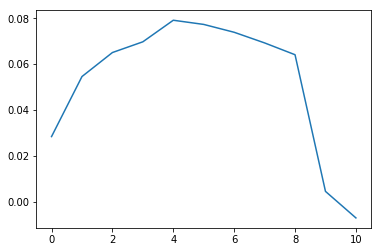

In [7]:
plt.plot(adjRs)

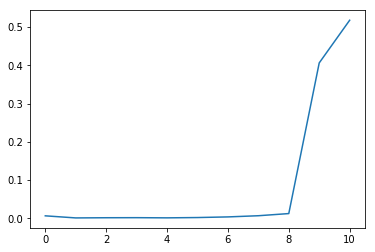

In [8]:
plt.plot(f_pvalues)

## Run OLS model with surface variables only (high data capture, filtered by UA)
**We only want to use features with high data capture in the training years**

In [9]:
variables = ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', \
 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps',  'LXV_CloudCover_oktas', 'LXV_12hr_delta_Pressure_hp', \
 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_speed_kts', \
 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_speed_kts', \
 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_speed_kts', \
 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_speed_kts', \
 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_speed_kts', \
 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_speed_kts', \
 'KGJT_850mb_height_m', 'KGJT_850mb_tmpc', 'KGJT_850mb_dwpc', 'KGJT_850mb_speed_kts', \
 'KGJT_d850_700_height_m', 'KGJT_d850_700_tmpc', 'KGJT_d850_700_dwpc', 'KGJT_d850_700_speed_kts', \
 'KGJT_d850_500_height_m', 'KGJT_d850_500_tmpc', 'KGJT_d850_500_dwpc', 'KGJT_d850_500_speed_kts', \
 'KGJT_d850_400_height_m', 'KGJT_d850_400_tmpc', 'KGJT_d850_400_dwpc', 'KGJT_d850_400_speed_kts', \
 'KGJT_d850_300_height_m', 'KGJT_d850_300_tmpc', 'KGJT_d850_300_dwpc', 'KGJT_d850_300_speed_kts', \
 'KGJT_d850_250_height_m', 'KGJT_d850_250_tmpc', 'KGJT_d850_250_dwpc', 'KGJT_d850_250_speed_kts', \
 'KGJT_d850_200_height_m', 'KGJT_d850_200_tmpc', 'KGJT_d850_200_dwpc', 'KGJT_d850_200_speed_kts',\
 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc', 'KGJT_d700_500_speed_kts', \
 'KGJT_d700_400_height_m', 'KGJT_d700_400_tmpc', 'KGJT_d700_400_dwpc', 'KGJT_d700_400_speed_kts', \
 'KGJT_d700_300_height_m', 'KGJT_d700_300_tmpc', 'KGJT_d700_300_dwpc', 'KGJT_d700_300_speed_kts', \
 'KGJT_d700_250_height_m', 'KGJT_d700_250_tmpc', 'KGJT_d700_250_dwpc', 'KGJT_d700_250_speed_kts', \
 'KGJT_d700_200_height_m', 'KGJT_d700_200_tmpc', 'KGJT_d700_200_dwpc', 'KGJT_d700_200_speed_kts', \
 'KGJT_d500_400_height_m', 'KGJT_d500_400_tmpc', 'KGJT_d500_400_dwpc', 'KGJT_d500_400_speed_kts', \
 'KGJT_d500_300_height_m', 'KGJT_d500_300_tmpc', 'KGJT_d500_300_dwpc', 'KGJT_d500_300_speed_kts', \
 'KGJT_d500_250_height_m', 'KGJT_d500_250_tmpc', 'KGJT_d500_250_dwpc', 'KGJT_d500_250_speed_kts', \
 'KGJT_d500_200_height_m', 'KGJT_d500_200_tmpc', 'KGJT_d500_200_dwpc', 'KGJT_d500_200_speed_kts', \
 'KGJT_d400_300_height_m', 'KGJT_d400_300_tmpc', 'KGJT_d400_300_dwpc', 'KGJT_d400_300_speed_kts', \
 'KGJT_d400_250_height_m', 'KGJT_d400_250_tmpc', 'KGJT_d400_250_dwpc', 'KGJT_d400_250_speed_kts', \
 'KGJT_d400_200_height_m', 'KGJT_d400_200_tmpc', 'KGJT_d400_200_dwpc', 'KGJT_d400_200_speed_kts', \
 'KGJT_d300_250_height_m', 'KGJT_d300_250_tmpc', 'KGJT_d300_250_dwpc', 'KGJT_d300_250_speed_kts', \
 'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc', 'KGJT_d300_200_speed_kts', \
 'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc', 'KGJT_d250_200_speed_kts']

good_vars = []
bad_vars = []
for var in variables:
    idx = np.isfinite(asos_snotel_UA_df[all_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']) & np.isfinite(asos_snotel_UA_df[all_yrs][var])
 #   total_poss = len(asos_snotel_UA_df[all_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][asos_snotel_UA_df[all_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=0])
    
    total_poss = asos_snotel_UA_df[all_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'].count()   #counts only non missing values
    total_avail =len(asos_snotel_UA_df[all_yrs][idx]) 
    
    if total_avail/total_poss >= 0.67: 
        good_vars.append(var)
    else:
        bad_vars.append(var)
        
#Filter out surface data
sfc_good_vars = [k for k in good_vars if 'CMtn' in k] + [k for k in good_vars if 'LXV' in k]
        
print('SURFACE Variables with >= 67% data match to snowfall: ')
print(sfc_good_vars)
print('Variables with < 67% data match to snowfall: ')
print(bad_vars)
    




SURFACE Variables with >= 67% data match to snowfall: 
['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_12hr_delta_Pressure_hp']
Variables with < 67% data match to snowfall: 
['CMtn_CloudCover_oktas', 'LXV_CloudCover_oktas', 'KGJT_850mb_tmpc', 'KGJT_850mb_dwpc', 'KGJT_850mb_speed_kts', 'KGJT_d850_700_tmpc', 'KGJT_d850_700_dwpc', 'KGJT_d850_700_speed_kts', 'KGJT_d850_500_tmpc', 'KGJT_d850_500_dwpc', 'KGJT_d850_500_speed_kts', 'KGJT_d850_400_tmpc', 'KGJT_d850_400_dwpc', 'KGJT_d850_400_speed_kts', 'KGJT_d850_300_tmpc', 'KGJT_d850_300_dwpc', 'KGJT_d850_300_speed_kts', 'KGJT_d850_250_tmpc', 'KGJT_d850_250_dwpc', 'KGJT_d850_250_speed_kts', 'KGJT_d850_200_tmpc', 'KGJT_d850_200_dwpc', 'KGJT_d850_200_speed_kts']


**Because we will want an apples to apples type comparision with the OLS model we perform with Surface+UA data, we must be sure sure to use the same snowfall data. **For every snowfall amount used, there must be a datapoint for every corresponding surface and upper air data features.  Therefore, any rows with an NaN value will be removed from the analysis.

In [10]:
good_vars_snf =[]
filtered_asos_snotel_UA_df = pd.DataFrame()


#df_sfc = asos_snotel_UA_df[['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', \
#                           'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp','CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']].copy()
#
#df = asos_snotel_UA_df[df = asos_snotel_UA_df[['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', \
#                        'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', \
#                        'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', \
#                        'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', \
#                        'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', \
#                        'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', \
#                        'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', \
#                        'KGJT_d850_500_height_m', 'KGJT_d850_400_height_m', 'KGJT_d850_300_height_m', 'KGJT_d850_250_height_m', 'KGJT_d850_200_height_m', 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc', 'KGJT_d700_500_drct', 'KGJT_d700_500_speed_kts', 'KGJT_d700_400_height_m', 'KGJT_d700_400_tmpc', 'KGJT_d700_400_dwpc', 'KGJT_d700_400_drct', 'KGJT_d700_400_speed_kts', 'KGJT_d700_300_height_m', 'KGJT_d700_300_tmpc', 'KGJT_d700_300_dwpc', 'KGJT_d700_300_drct', 'KGJT_d700_300_speed_kts', 'KGJT_d700_250_height_m', 'KGJT_d700_250_tmpc', 'KGJT_d700_250_dwpc', 'KGJT_d700_250_drct', 'KGJT_d700_250_speed_kts', 'KGJT_d700_200_height_m', 'KGJT_d700_200_tmpc', 'KGJT_d700_200_dwpc', 'KGJT_d700_200_drct', 'KGJT_d700_200_speed_kts', 'KGJT_d500_400_height_m', 'KGJT_d500_400_tmpc', 'KGJT_d500_400_dwpc', 'KGJT_d500_400_drct', 'KGJT_d500_400_speed_kts', 'KGJT_d500_300_height_m', 'KGJT_d500_300_tmpc', 'KGJT_d500_300_dwpc', 'KGJT_d500_300_drct', 'KGJT_d500_300_speed_kts', 'KGJT_d500_250_height_m', 'KGJT_d500_250_tmpc', 'KGJT_d500_250_dwpc', 'KGJT_d500_250_drct', 'KGJT_d500_250_speed_kts', 'KGJT_d500_200_height_m', 'KGJT_d500_200_tmpc', 'KGJT_d500_200_dwpc', 'KGJT_d500_200_drct', 'KGJT_d500_200_speed_kts', 'KGJT_d400_300_height_m', 'KGJT_d400_300_tmpc', 'KGJT_d400_300_dwpc', 'KGJT_d400_300_drct', 'KGJT_d400_300_speed_kts', 'KGJT_d400_250_height_m', 'KGJT_d400_250_tmpc', 'KGJT_d400_250_dwpc', 'KGJT_d400_250_drct', 'KGJT_d400_250_speed_kts', 'KGJT_d400_200_height_m', 'KGJT_d400_200_tmpc', 'KGJT_d400_200_dwpc', 'KGJT_d400_200_drct', 'KGJT_d400_200_speed_kts', 'KGJT_d300_250_height_m', 'KGJT_d300_250_tmpc', 'KGJT_d300_250_dwpc', 'KGJT_d300_250_drct', 'KGJT_d300_250_speed_kts', 'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc', 'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts', \
#                        'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc', 'KGJT_d250_200_drct', \
#                         'KGJT_d250_200_speed_kts','CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']].copy()

good_vars_snf = sfc_good_vars + ['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']
print(good_vars_snf )
filtered_asos_snotel_UA_df=  asos_snotel_UA_df[good_vars_snf].copy()
test_train_df = asos_snotel_UA_df[good_vars_snf].dropna()
#test_df = asos_snotel_UA_df[good_vars_snf][test_yrs].dropna()
#train_df = asos_snotel_UA_df[good_vars_snf][train_yrs].dropna()

#print(test_df.describe())
#print(train_df.describe())
#print(filtered_asos_snotel_UA_df[train_yrs].dropna().describe())
print(test_train_df)

['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_12hr_delta_Pressure_hp', 'CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']
                           CMtnSNTL_Temp_degC  CMtn_Temperature_degC  \
Date_Time                                                              
2006-01-01 12:00:00+00:00                -3.2                   -7.0   
2006-01-08 12:00:00+00:00                -6.2                   -9.0   
2006-01-12 12:00:00+00:00                -8.2                   -9.0   
2006-01-18 00:00:00+00:00                -8.0                   -9.0   
2006-01-19 00:00:00+00:00                -4.3                   -8.0   
2006-01-29 00:00:00+00:00                -9.7                  -14.0   
2006-02-02 00:00:00+00:00                -4.3                   -8.0   
2006-02-05 00:00:00+00:00                -5.3                   -6.0   
2006-03-09 12:00:00+00:00       

In [11]:
import statistics as sts
all_yrs_tt = (test_train_df.index >= '01-01-2006') & (test_train_df.index < '01-01-2018')
train_yrs_tt=  ((test_train_df.index >= '01-01-2006') & (test_train_df.index < '01-01-2015')) | ((test_train_df.index >= '01-01-2015') & (test_train_df.index < '01-01-2018'))
test_yrs_tt = (test_train_df.index >= '01-01-2014') & (test_train_df.index < '01-01-2015')



### Run model with good SURFACE variables

In [12]:
from collections import OrderedDict

variables = ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', \
'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', \
'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_12hr_delta_Pressure_hp']
variables_org = variables
print(variables)

print('******')
adjRs = []
newRs = []
dup_var = []
max_vars = []
f_pvalues = []

while variables != []:
  #print(variables)
  for var in variables:

        
    #print(variables)
    max_var = max(variables, key = lambda v: ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + v, test_train_df[train_yrs_tt]).fit().rsquared_adj)    #this finds OLS model run with highest adj R squared
    OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + max_var, test_train_df[train_yrs_tt]).fit()
    
    print(max_var)
    #print(max_var)
    #print(OLS.rsquared)
    
    #Create lists of statistics for each combination of variables modeld
    adjRs.append(OLS.rsquared_adj)
    f_pvalues.append(OLS.f_pvalue)
    max_vars.append(max_var)

    add_max_var = '+ '+ max_var
    
    variables = [s + add_max_var for s in variables_org]
    
    #The above for loop naturally will create a duplicate variable, which should be removed
    for v in variables_org: 
      dup_var = []
      dup_var = [var for var in variables if var.count(v)>1]
      if dup_var!=[]:
            for dup in dup_var: variables.remove(dup)

#combine the modeled variable sequences with respective stats  
stats = list(zip(adjRs, f_pvalues))    # create list of tuples
dictionary = OrderedDict(zip(max_vars, stats))
#dictionary_adjRs = OrderedDict(zip(max_vars, f_pvalues))
print(adjRs)
print(max_vars)
print(f_pvalues)
print(dictionary)

['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_12hr_delta_Pressure_hp']
******
CMtn_Dewpoint_degC
CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
LXV_12hr_delta_Pressure_hp+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
CMtn_Temperature_degC+ LXV_12hr_delta_Pressure_hp+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
LXV_Temperature_degC+ CMtn_Temperature_degC+ LXV_12hr_delta_Pressure_hp+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
LXV_Dewpoint_degC+ LXV_Temperature_degC+ CMtn_Temperature_degC+ LXV_12hr_delta_Pressure_hp+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
LXV_WindSpeed_mps+ LXV_Dewpoint_degC+ LXV_Temperature_degC+ CMtn_Temperature_degC+ LXV_12hr_delta_Pressure_hp+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
LXV_Pressure_hp+ LXV_WindSpeed_mps+ LXV_Dewpoint_degC+ LXV_Temperature_degC+ CMtn_Temperature_degC+ LXV_12hr_delta_Pressure_hp+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
CMtnSNTL_Te

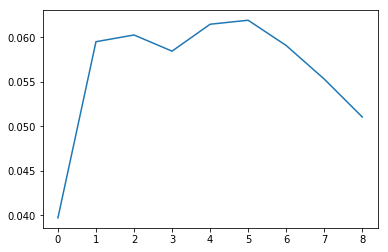

In [13]:
plt.plot(adjRs)

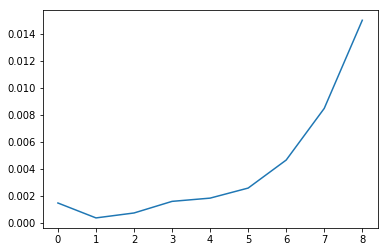

In [14]:
plt.plot(f_pvalues)

**Print adjusted R and F stat probabilities in order**

In [15]:


for c in dictionary:
    #print(str(dictionary.keys().index(c))+"{country}: {capital}".format(country=c, capital=dictionary[c])+"\n")
        print(str(list(dictionary.keys()).index(c))+ " {key} \n Adjusted R: {adjR}  Fstat(prob): {f_pvalue}".format(key=c, adjR=dictionary[c][0], f_pvalue = dictionary[c][1])+"\n")
        OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + c, test_train_df[train_yrs_tt]).fit()



0 CMtn_Dewpoint_degC 
 Adjusted R: 0.03972669604440826  Fstat(prob): 0.0014856651517758176

1 CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC 
 Adjusted R: 0.059518875038556684  Fstat(prob): 0.0003826857255916994

2 LXV_12hr_delta_Pressure_hp+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC 
 Adjusted R: 0.06027415951775261  Fstat(prob): 0.0007478041936278331

3 CMtn_Temperature_degC+ LXV_12hr_delta_Pressure_hp+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC 
 Adjusted R: 0.058457690250049654  Fstat(prob): 0.0016056304595862855

4 LXV_Temperature_degC+ CMtn_Temperature_degC+ LXV_12hr_delta_Pressure_hp+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC 
 Adjusted R: 0.06148072860189946  Fstat(prob): 0.0018456661811988044

5 LXV_Dewpoint_degC+ LXV_Temperature_degC+ CMtn_Temperature_degC+ LXV_12hr_delta_Pressure_hp+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC 
 Adjusted R: 0.06192914617064327  Fstat(prob): 0.0025892887091197333

6 LXV_WindSpeed_mps+ LXV_Dewpoint_degC+ LXV_Temperature_degC+ CMtn_Temperature_degC+ LXV_12hr_delta_Pr

**Find max adj R and obtain OLS summary**

In [16]:
 # Just use 'min' instead of 'max' for minimum.
print("Print maximum:")
maximum = max(dictionary, key=dictionary.get) 
print(maximum)

Print maximum:
LXV_Dewpoint_degC+ LXV_Temperature_degC+ CMtn_Temperature_degC+ LXV_12hr_delta_Pressure_hp+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC


In [17]:
maximum_all_str = max(dictionary, key=dictionary.get) 
print(maximum_all_str)

maxOLS_all = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + maximum_all_str , asos_snotel_UA_df[train_yrs]).fit() 
print(maxOLS_all.summary())


LXV_Dewpoint_degC+ LXV_Temperature_degC+ CMtn_Temperature_degC+ LXV_12hr_delta_Pressure_hp+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
                                      OLS Regression Results                                     
Dep. Variable:     CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in   R-squared:                       0.090
Model:                                               OLS   Adj. R-squared:                  0.060
Method:                                    Least Squares   F-statistic:                     3.009
Date:                                   Sat, 13 Apr 2019   Prob (F-statistic):            0.00790
Time:                                           22:06:45   Log-Likelihood:                -386.13
No. Observations:                                    190   AIC:                             786.3
Df Residuals:                                        183   BIC:                             809.0
Df Model:                                              6                             

**Print QQ plot**

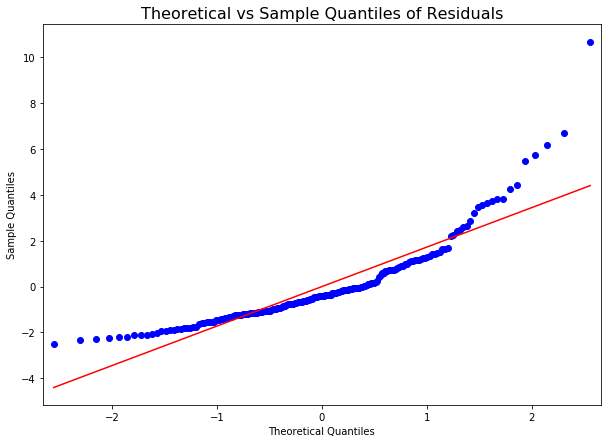

In [18]:
fig, ax = plt.subplots(figsize=(10, 7))
qq2=sm.qqplot(maxOLS_all.resid, line='r', ax = ax)
plt.title('Theoretical vs Sample Quantiles of Residuals', fontsize = 16)
plt.savefig('C:/Users/RAPP/Documents/Capstone/Report/figs/qq_resid_SFC_2014_noWD.png',bbox_inches='tight')

Let's test different P|t| thresholds for which to remove variables, rerun and model for each set of variables, and see what threshold might glean best results using adjusted R squared as a metric**

In [19]:
rsq_adj = 0
thresh = 0

goodp_str = ""
highp_var = []

maximum_all_str = max(dictionary, key=dictionary.get)    #this is the string of variables found in previous OLS run associated with mad adjusted R squared.
print(maximum_all_str)


for test_thresh in range(1, 100):   #loop through different P|t| thresholds ranging from 1 to 100.  Note floats are not allowed here 
  print(test_thresh)
  highp_var = [var for var in maxOLS_all.pvalues.keys() if maxOLS_all.pvalues[var]>=test_thresh*0.01]  #check P|t| for each variable against threshold and store in list
  
  testgoodp_str = maximum_all_str   #reset testgoodp_str 
    
  for var in highp_var:
    testgoodp_str = testgoodp_str.replace("+ " + var, "")   #  
     

 

  maxOLS_testgoodp = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + testgoodp_str, asos_snotel_UA_df[train_yrs]).fit()
  print(testgoodp_str, maxOLS_testgoodp.rsquared_adj, test_thresh*0.01)
  #print(maxOLS_testgoodp.rsquared_adj)
  if maxOLS_testgoodp.rsquared_adj > rsq_adj:
      rsq_adj = maxOLS_testgoodp.rsquared_adj
      print(maxOLS_testgoodp.rsquared_adj, test_thresh*0.01)
      goodp_str = testgoodp_str
      thresh = test_thresh*0.01

    
print("\n best threshold is:" + str(thresh))
maxOLS_goodp = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + goodp_str, asos_snotel_UA_df[train_yrs]).fit() 
print(maxOLS_goodp.summary())


LXV_Dewpoint_degC+ LXV_Temperature_degC+ CMtn_Temperature_degC+ LXV_12hr_delta_Pressure_hp+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC
1
LXV_Dewpoint_degC 0.0214839214952105 0.01
0.0214839214952105 0.01
2
LXV_Dewpoint_degC 0.0214839214952105 0.02
3
LXV_Dewpoint_degC 0.0214839214952105 0.03
4
LXV_Dewpoint_degC+ LXV_Temperature_degC 0.018994427865870578 0.04
5
LXV_Dewpoint_degC+ LXV_Temperature_degC 0.018994427865870578 0.05
6
LXV_Dewpoint_degC+ LXV_Temperature_degC+ CMtn_Dewpoint_degC 0.02538392205871276 0.06
0.02538392205871276 0.06
7
LXV_Dewpoint_degC+ LXV_Temperature_degC+ CMtn_Dewpoint_degC 0.02538392205871276 0.07
8
LXV_Dewpoint_degC+ LXV_Temperature_degC+ CMtn_Dewpoint_degC 0.02538392205871276 0.08
9
LXV_Dewpoint_degC+ LXV_Temperature_degC+ CMtn_Dewpoint_degC 0.02538392205871276 0.09
10
LXV_Dewpoint_degC+ LXV_Temperature_degC+ CMtn_Dewpoint_degC 0.02538392205871276 0.1
11
LXV_Dewpoint_degC+ LXV_Temperature_degC+ CMtn_Dewpoint_degC 0.02538392205871276 0.11
12
LXV_Dewpoint_degC+ LXV_Tem

LXV_Dewpoint_degC+ LXV_Temperature_degC+ CMtn_Temperature_degC+ LXV_12hr_delta_Pressure_hp+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC 0.05996259483933852 0.6900000000000001
70
LXV_Dewpoint_degC+ LXV_Temperature_degC+ CMtn_Temperature_degC+ LXV_12hr_delta_Pressure_hp+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC 0.05996259483933852 0.7000000000000001
71
LXV_Dewpoint_degC+ LXV_Temperature_degC+ CMtn_Temperature_degC+ LXV_12hr_delta_Pressure_hp+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC 0.05996259483933852 0.71
72
LXV_Dewpoint_degC+ LXV_Temperature_degC+ CMtn_Temperature_degC+ LXV_12hr_delta_Pressure_hp+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC 0.05996259483933852 0.72
73
LXV_Dewpoint_degC+ LXV_Temperature_degC+ CMtn_Temperature_degC+ LXV_12hr_delta_Pressure_hp+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC 0.05996259483933852 0.73
74
LXV_Dewpoint_degC+ LXV_Temperature_degC+ CMtn_Temperature_degC+ LXV_12hr_delta_Pressure_hp+ CMtn_WindSpeed_mps+ CMtn_Dewpoint_degC 0.05996259483933852 0.74
75
LXV_Dewpoint_degC+

**So it looks like the best P|t| threshold for variable elimination is 0.27.  A small improvement to adjusted R squared was made**

## Try fit parameters with test dataset (2014 test data)

count    37.000000
mean      5.716216
std       2.605604
min       3.000000
25%       4.000000
50%       5.000000
75%       6.000000
max      14.000000
Name: CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in, dtype: float64
count    37.000000
mean      4.496870
std       0.488331
min       3.473009
25%       4.181169
50%       4.473282
75%       4.806933
max       5.425599
dtype: float64
count       37
unique       1
top       True
freq        37
dtype: object
Date_Time
2014-01-01 00:00:00+00:00    4.653026
2014-01-01 12:00:00+00:00    4.863934
2014-01-04 12:00:00+00:00    4.190812
2014-01-10 00:00:00+00:00    4.027410
2014-01-10 12:00:00+00:00    3.520234
2014-01-12 12:00:00+00:00    4.748237
2014-01-14 00:00:00+00:00    4.456737
2014-01-27 12:00:00+00:00    4.800401
2014-01-30 00:00:00+00:00    4.265627
2014-01-30 12:00:00+00:00    4.621359
2014-01-31 00:00:00+00:00    4.181169
2014-02-09 00:00:00+00:00    5.018272
2014-03-01 12:00:00+00:00    4.907720
2014-03-05 00:00:00+00:00    4.936590
2014-

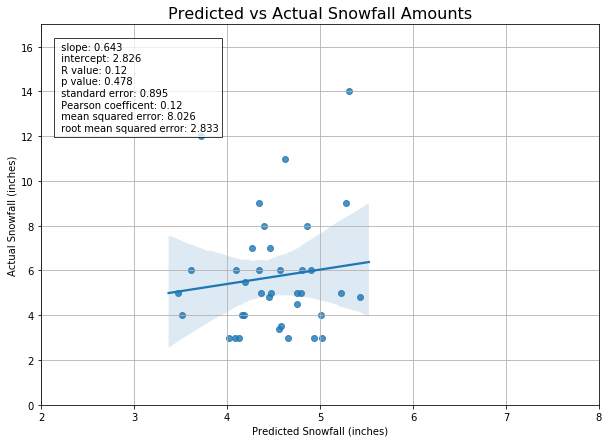

In [20]:
fig = plt.figure(figsize=(10,7))



#Define actual and predicted snowfall dataframes
actual_snf = test_train_df[test_yrs_tt]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']  #      [test_train_df[test_yrs_tt]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=3]
predict = maxOLS_goodp.predict(test_train_df[test_yrs_tt]) #    [test_train_df[test_yrs_tt]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=3])
print(actual_snf.describe())
print(predict.describe())

#Do linear regression and calcuate relevent stats

from scipy.stats import pearsonr, linregress
from sklearn.metrics import mean_squared_error


idx = np.isfinite(predict) & np.isfinite(actual_snf) 
print(idx.describe())

#print(test_train_df[test_yrs_tt][test_train_df['CMtnSNTL_Past12hrSNOWFALL_in']>=3].describe())


## Do linear regression and calculate slope, intercept, r, p, std err
slope1, intercept1, r_value1, p_value1, std_err1 = linregress(predict[idx], actual_snf[idx])
#Calculate mse and rmse
mse = mean_squared_error(actual_snf[idx].values,predict[idx].values)
rmse = np.sqrt(mse)
pearson1, pv = pearsonr(predict[idx], actual_snf[idx])

#plot and annotate
sns.regplot(predict[idx].values, actual_snf[idx].values)
bbox_props=dict(facecolor='red', alpha=0.75, fc = 'white')
plt.annotate(' slope: ' + str(round(slope1,3)) +
                 '\n intercept: ' + str(round(intercept1,3)) + 
                 '\n R value: ' + str(round(r_value1,3)) +  
                 '\n p value: ' + str(round(p_value1,3)) + 
                 '\n standard error: ' + str(round(std_err1,3)) +
                 '\n Pearson coefficent: ' + str(round(pearson1,3)) +
                 '\n mean squared error: ' + str(round(mse,3)) +
                 '\n root mean squared error: ' + str(round(rmse,3)), \
                 xy=(0.03, 0.72), xycoords='axes fraction', fontsize=10, bbox = bbox_props)

plt.xlabel('Predicted Snowfall (inches)')
plt.ylabel('Actual Snowfall (inches)')
plt.xlim([2,8])
plt.ylim([0,17])
plt.grid(True)


plt.savefig('C:/Users/RAPP/Documents/Capstone/Report/figs/pred_vs_act_SFC_2014_noWD.png',bbox_inches='tight')
plt.title('Predicted vs Actual Snowfall Amounts', fontsize = 16)

print(predict[idx])
print(actual_snf[idx])

**Plot Residuals**

[4.65302595 4.86393436 4.19081171 4.02741044 3.52023388 4.74823702
 4.45673737 4.80040074 4.26562683 4.62135914 4.18116934 5.01827179
 4.90771996 4.9365897  4.34282892 4.36872079 4.5836848  4.09298389
 4.80693297 4.08857889 4.74819522 4.40025619 5.22702169 4.47328154
 4.55813879 5.42559902 5.30927014 5.00931641 3.60889955 3.47300936
 4.46709895 4.56555432 3.72447074 4.16364373 4.12585585 4.3456966
 5.28362888]
[ 3.   8.   5.5  3.   4.   5.   4.8  5.   7.  11.   4.   3.   6.   3.
  6.   5.   3.5  6.   6.   3.   4.5  8.   5.   5.   3.4  4.8 14.   4.
  6.   5.   7.   6.  12.   4.   3.   9.   9. ]


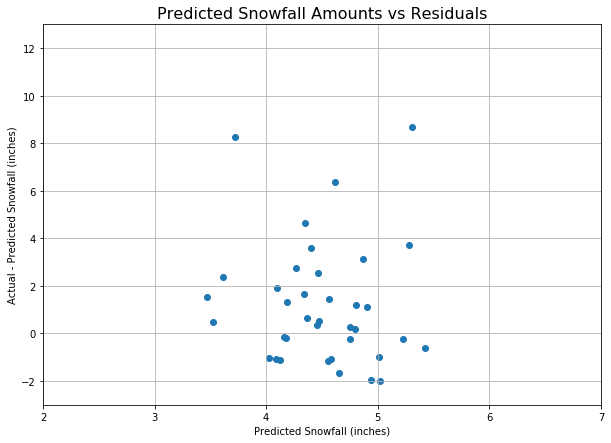

In [21]:
fig = plt.figure(figsize=(10,7))

plt.scatter(predict[idx].values, actual_snf[idx].values-predict[idx].values)
print(predict[idx].values)
print(actual_snf[idx].values)
#print(actual_snf[idx].values-predict[idx].values)

plt.ylabel('Actual - Predicted Snowfall (inches)')
plt.xlabel('Predicted Snowfall (inches)')
plt.xlim([2,7])
plt.ylim([-3,13])
plt.grid(True)
plt.title('Predicted Snowfall Amounts vs Residuals', fontsize = 16)

plt.savefig('C:/Users/RAPP/Documents/Capstone/Report/figs/resid_vs_pred_SFC_2014_noWD.png',bbox_inches='tight')


Text(0.5,1,'Theoretical vs Sample Quantiles of Residuals')

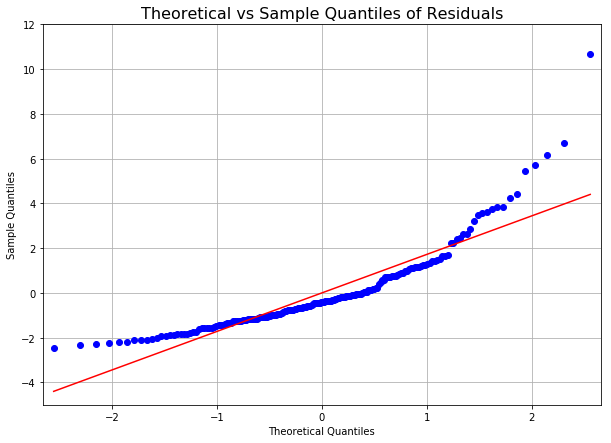

In [22]:
fig, ax = plt.subplots(figsize=(10, 7))
qq2=sm.qqplot( maxOLS_testgoodp.resid, line='r', ax = ax)

plt.ylim([-5,12])

plt.grid(True)
plt.savefig('C:/Users/RAPP/Documents/Capstone/Report/figs/qq_resid_SFC_2014_noWD.png',bbox_inches='tight')
plt.title('Theoretical vs Sample Quantiles of Residuals', fontsize = 16)

Text(0.5,1,'Histogram of Residuals')

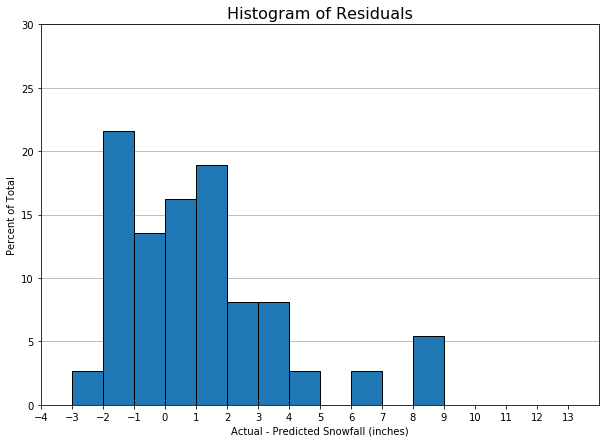

In [24]:
diff = actual_snf[idx].values-predict[idx].values
diff_df = pd.DataFrame(diff)
fig = plt.figure(figsize=(10, 7))
ax = plt.subplot(1,1,1)

#plt.hist(diff, bins = np.arange(-4,14,0.5), histtype = 'bar')
weights = np.ones_like(diff)/float(len(diff))
plt.hist(diff, histtype = 'bar', weights=weights*100, \
           bins = np.arange(-4,14,1), align = 'mid', edgecolor = 'black') 

plt.xlabel('Actual - Predicted Snowfall (inches)')
plt.ylabel('Percent of Total')
plt.xlim([-4,14])
#plt.ylim([0,10])
#plt.grid(True)

plt.xticks(np.arange(-4,14,1))
plt.yticks(np.arange(0,31,5))
ax.set_axisbelow(True)   #places gridlines behind bars
plt.grid(True, axis = 'y')
plt.title('')

plt.savefig('C:/Users/RAPP/Documents/Capstone/Report/figs/hist_actual_minus_pred_SFC_2014_noWD.png',bbox_inches='tight')
plt.title('Histogram of Residuals', fontsize = 16)

